In [27]:
#In this notebook, you'll learn how to implement a Generative Adversarial Network (GAN).
#The goal of a GAN is to create one network - a "Generator" - which seeks to create pictures
#of something (in our case, beaches); the second network is a "Discriminator", which examines
#our generated pictures and tries to determine if they are fake or real.
#The generator network learns over multiple iterations to "fool" the discriminator - 
#hopefully creating some good looking beaches!

import keras
import pandas as pd
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import numpy as np

#Note in our data generator, we're only keeping augmentation that wouldn't
#look funny to the human eye - flipping.
dataGenerator = keras.preprocessing.image.ImageDataGenerator(validation_split=0.3, 
                                                             horizontal_flip=True,#Randomly horizontal flip
                                                             vertical_flip=True #Random vertical flip
                                                             )


#Note we're only going to use a training dataset here.
#Our test of accuracy will ultimately be qualitative - how good the beach looks.
train = dataGenerator.flow_from_directory("./mercerBeaches", class_mode='categorical', 
                                            batch_size=32, 
                                            target_size=(256,256))                                       



Found 100 images belonging to 1 classes.


In [60]:
#Now, let's build the model that will discrimante - i.e., determine if something is a beach or not.
#Note we have a fairly small dataset, so some of the thigns we're doing here (i.e., dropout) are really
#reflective of best practices in larger-N cases, and not going to help us much here.

def discriminator():
    m = keras.models.Sequential()
    
    #Here's a short convolutional network, using
    #Leaky ReLUs and dropouts as examples.
    #You could definitely build something better,
    #or use existing nets like ResNet if you wanted.
    m.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(4,4),
                              activation="tanh",
                              input_shape=(256,256,3)))
    m.add(keras.layers.LeakyReLU(alpha=0.1))                    
    m.add(keras.layers.Dropout(0.5))
    m.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(4,4),
                              activation="tanh",
                              input_shape=(256,256,3)))
    m.add(keras.layers.LeakyReLU(alpha=0.1))                    
    m.add(keras.layers.Dropout(0.5))
    m.add(keras.layers.Flatten())

    #Note we have 1 output with sigmoid here - i.e., we'll get one output value from 0 to 1.
    #This will be our "probability it's a beach"
    #With more data, you would probably want more dense layers here, but we'll just do one.
    m.add(keras.layers.Dense(1, activation='sigmoid'))

    m.compile(optimizer=keras.optimizers.SGD(learning_rate=.001),
                                            loss='binary_crossentropy',
                                            metrics=['accuracy'])
    return(m)

model = discriminator()

print(model.summary())


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 253, 253, 64)      3136      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 253, 253, 64)      0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 253, 253, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 250, 250, 64)      65600     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 250, 250, 64)      0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 250, 250, 64)      0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4000000)         

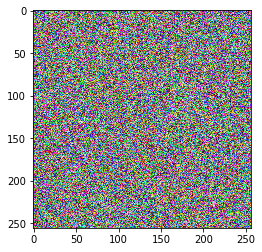

In [31]:
#Now, we need an algorithm that generates fake samples that are
#definitely not beaches.

def generateNotBeaches(batchSize):
    #Here, 256*256*3 is our iomage sizes; 32 is the batch size.
    X = np.random.rand(256*256*3*batchSize)
    X = X.reshape((batchSize,256,256,3))
    y = np.zeros((batchSize,1))
    return(X,y)

notBeach = generateNotBeaches(1)

#See, look, not a beach!
plt.imshow(notBeach[0][0], interpolation='nearest')
plt.show()



In [61]:
#Now we can train our model to discrimate between noise and a beach
#Note I include the model initialization here so the weights get trained from
#a random state each time you run this cell.
model = discriminator()

#Note this will train very quickly - i.e., it's pretty darn easy to tell the difference
#between a beach and random noise!  Note that because we have such a small dataset,
#you may have to run this a few times to hit a good solution set.
#(Also keep in mind we're using image augmentation, so if you're struggling
#to get this to work, adding more augmentations can be very helpful.)
epochs = 10

#Batch size 
batchSize = 32

#Calculate the number of iterations needed for an epoch (i.e., to go through all data):
#Assuming a batch size of 32 here:
iterations = int(np.ceil(train.samples / batchSize))
print("Total Iterations per Epoch: " + str(iterations))
for j in range(epochs):
    i = 1
    for beachX, beachY in train:
        print("================")
        print("Epoch " + str(j+1) + "| Starting iteration " + str(i))
        #First we pass our beach data through
        print("Fitting on real beach data.")
        _, realBeachAcc = model.train_on_batch(beachX, beachY)
        print("Percent of Real Beaches Identified as Real: " + str(realBeachAcc*100))
        #Now we pass our fake data through - we seperate this out on purpose, so we can use a generator seperately later!
        print("Fitting on generated fake data.")
        notBeachX, notBeachY = generateNotBeaches(batchSize)
        _, fakeBeachAcc = model.train_on_batch(notBeachX, notBeachY)
        print("Percent of Fake Beaches Identified as Fake: " + str(fakeBeachAcc*100))
        if i >= iterations:
            break

        i = i + 1

    

Total Iterations per Epoch: 4
Epoch 1| Starting iteration 1
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 1| Starting iteration 2
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 96.875
Epoch 1| Starting iteration 3
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 96.875
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 1| Starting iteration 4
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 100.0
Epoch 2| Starting iteration 1
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 100.0
Epoch 2| Starting iter

In [105]:
#Ok!  Now we're going to create a real generator model.
#Basically, instead of using the random noise like we did above,
#we want a model that can generate images and learn to fool our
#discriminating model.
#The idea here is that we take as input some set of weights - 
#i.e., a random vector, and output our image.  The goal is to 
#find the weights that work best.

def beachGenerator():
    m = keras.models.Sequential()
    
    m.add(keras.layers.Dense(3*8*8,input_dim=100))     #We're going to start at a very coarse resoltution (8x8), and upscale our way to glory!
                                                        #Note the ,100 here represents the number of input weights we'll have.
    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Reshape((8,8,3))) #Put our dimensions first for upsampling
    
    #Here, we're essentially doing a reverse-convolution, as we'll discuss in lecture.
    #The idea is that we're going to create more pixels from a single pixel based on
    #a kernel size and stride, which will give use weights.
    #This will change our image from 8x8x3 to 25x25x3:
    m.add(keras.layers.Conv2DTranspose(3,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Conv2DTranspose(3,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Conv2DTranspose(3,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Conv2DTranspose(3,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Conv2DTranspose(3,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.experimental.preprocessing.Rescaling(scale=255, offset=1))

    m.compile(optimizer=keras.optimizers.SGD(learning_rate=.001),
                                            loss='binary_crossentropy',
                                            metrics=['accuracy'])
    return(m)
generatorModel = beachGenerator()
generatorModel.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 192)               19392     
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 192)               0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 8, 8, 3)           0         
_________________________________________________________________
conv2d_transpose_86 (Conv2DT (None, 16, 16, 3)         39        
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_transpose_87 (Conv2DT (None, 32, 32, 3)         39        
_________________________________________________________________
leaky_re_lu_143 (LeakyReLU)  (None, 32, 32, 3)       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


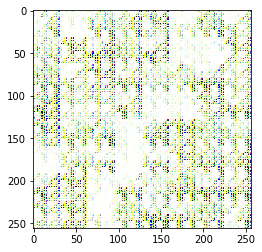

In [108]:
#Now, let's show off how the model can be used to generate some data.
#First, we need to create some random inputs for it to start with - 
#remember, our inputs are a 100-dimension vector, from our densenet.
#(This can be arbitrarily high or low, depending on your problem)

def generateFakeBeach(genModel, batchSize):
    rndInput = np.random.randn(100 * batchSize)
    rndInput = rndInput.reshape(batchSize, 100)
    X = genModel.predict(rndInput)
    y = np.zeros((batchSize, 1))
    return(X,y)

generatorModel = beachGenerator()
X,y = generateFakeBeach(generatorModel, 32)

#Still random data, but this time with random weights and upscaling!
plt.imshow(X[0], interpolation='nearest')
plt.show()